# Global warming simulator

The following code simulates the time-dependent global warming due to a strengthening greenhouse effect caused by human emissions of greenhouse gases. The current version of the model omits the effect of naturally occuring greenhouse gases in reducing outgoing longwave (thermal) radiation and so is unrealistically sensitive to greenhouse gas emissions. A more realistic model would take into account the natural greenhouse effect as well as other feedbacks, such as the ice-albedo effect and feedbacks involving atmospheric winds or ocean currents. 

You can swap out the parameter $B$ for a smaller gray-gas value for a better estimate of the model's sensitivity to radiative forcing. The code will hopefully soon be expanded to include a deep-ocean reservoir for heat, roughly following Held et al. 2009 (https://journals.ametsoc.org/doi/full/10.1175/2009JCLI3466.1).

In [37]:
using Unitful
ENV["PYTHON"]="";

In [38]:
]build PyCall PyPlot

  Building Conda ─→ `~/.julia/packages/Conda/kLXeC/deps/build.log`
  Building PyCall → `~/.julia/packages/PyCall/ttONZ/deps/build.log`


In [39]:
using PyPlot;

Consider the "Rock-Star" zero-dimensional system reviewed in Module 3.4 of [Prof. Michael Mann's edX course](https://www.edx.org/course/climate-change-the-science-and-global-impact) in which the solar radiation absorbed by Earth is balanced by its thermal radiation (giving by the Stefan-Boltzmann) relationship:
\begin{equation}
c_{f} \frac{\text{d}T}{\text{d}t} = \frac{S(1-\alpha)}{4} - \sigma T^{4} + F(t)
\end{equation}
where $\alpha=0.32$ is the albedo, $\sigma$ is the Stefan-Boltzmann constant, $T=255\text{ K}$ is the average surface temperature of Earth, $S=1360\text{ W/m}^{2}$ is the Solar Constant, and $c_{f}$ is the effective heat capacity per unit area of the Earth.

We have now added on $F(t)$ – the additional thermal flux trapped at Earth's surface due to the greenhouse effect of human-emitted greenhouse gasses (such as carbon dioxide CO$_{2}$ and methane CH$_{4}$).

We approximate the "business as usual" or "worst case" future emissions scenario known as RCP8.5 (meaning an increase in radiative forcing of $8.5\text{ W/m}^{2}$) by the piecewise linear function
\begin{equation}
F(t)=
    \begin{cases}
      0 \text{ W/m}^{2}, & \text{if}\ t<t_{0} \\
      \frac{8.5 \text{ W/m}^{2}}{100 \text{ years}} (t-t_{0}), & \text{if}\ t_{0}<t<t_{final} \\
      8.5 \text{ W/m}^{2}, & \text{if}\ t>t_{final}
    \end{cases}
\end{equation}
which is zero until $t=t_{0}$, then increases linearly from $F(t_{0})=0$ at $t_{0}=2000\text{ CE}$ to $F(t_{final})=8.5\text{ W/m}^{2}$ at $t_{final}=2100\text{ CE}$, and remains at its final value indefinitely.

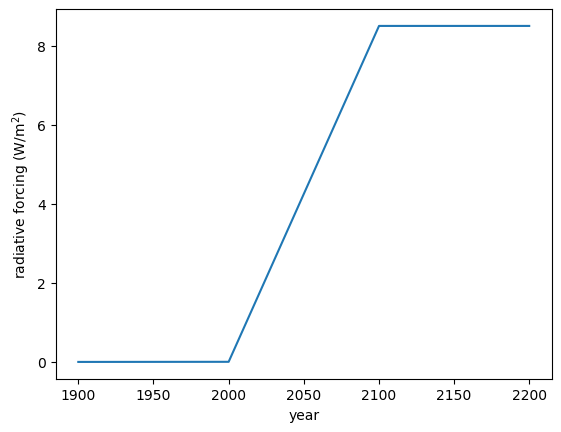

In [40]:
sec_in_year = (365. * 24. * 60. * 60.)u"s"
tinit = (1900. * sec_in_year); # initial time (year 1900)
t0 = (2000. * sec_in_year); # time that emissions begin (year 2000)
tfinal = (2100. * sec_in_year); # time that emissions end (year 2100)
Δt = (24. * 60. * 60.)u"s"; # 1 day time step
t = tinit:Δt:(tinit+(Δt * 300. * 365.)); # time array from 2000 to 2100

Ffinal = 8.5u"W/m^2";
F = zeros(size(t))u"W/m^2"
F[t.>t0] = Ffinal / (100. * sec_in_year) * (t[t.>t0] .- t0); # radiative forcing due to greenhouse effect
F[t.>tfinal] .= Ffinal;

# Make plot of radiative forcing
plot(t/sec_in_year,ustrip.(F))
xlabel("year")
ylabel(L"radiative forcing (W/m$^{2}$)");

Since the surface of the planet is mostly covered by oceans, a good first approximation for Earth's heat capacity is the heat capacity of the upper $100$ m of the ocean which are constantly mixed and efficiently exchange heat with the atmosphere. The heat capacity of this layer is given by $c_{f} = c_{p}\rho H$ where $c_{p} = 4180 \text{ J kg}^{-1}\text{ m}^{-2}$ is the specific heat capacity of water, $\rho = 1000 \text{ kg/m}^{3}$ is the density of water, and $H=100 \text{ m}$ is the thickness of the surface mixed layer.

In [43]:
H = 100u"m"; # depth of surface ocean mixed layer
ρ = 1000u"kg/m^3"; # density of liquid water 
c_p = 4180.0u"J/kg/K"; # specific heat capacity of liquid  water

c_f = c_p * ρ * H # upper ocean heat capacity

4.18e8 J K^-1 m^-2

For simplicity, we linearize the system around $t_{0}$, i.e. approximating $\sigma T^{4} \approx A + B(T-T_{0})$:

\begin{equation}
c_{f} \frac{\text{d}T}{\text{d}t} = \frac{S(1-\alpha)}{4} - A - B(T-T_{0}) + F(t)
\end{equation}

If we assume the system is at equilibrium before $t=t_{0}$, then we have simply
\begin{equation}
0=\frac{S(1-\alpha)}{4} - A
\end{equation}

If we then define $T'=T-T_{0}$ as the temperature *anomaly*, we have the simplified linear system for the evolution of the temperature anomaly:
\begin{equation}
c_{f} \frac{\text{d}T'}{\text{d}t} = - BT' + F(t)
\end{equation}

The linear coefficient $B$ is given by the derivative of $\sigma T^{4}$ with respect to $T$ evaluated at $T=T_{0}$,
\begin{equation}
B=4\sigma T_{0}^3
\end{equation}

In [44]:
T0 = 255u"K"; # equilibrium temperature 
σ = 5.67e-8u"W/m^2/K^4"; # Stefan-Boltzmann constant
B = 4 * σ  * (T0)^3; # derivative of outgoing flux to space with respect to T

# B = 1u"W/K/m^2"; # more realistic value (for the exercise below)

**Note:**
This conceptual model can be made more realistic by generalizing the outgoing longwave radiation (OLR) function from $\sigma T^{4}$ to $G(T)$, where $G(T)$ is an unknown function that describes how the greenhouse effect reduces the outgoing longwave radiation by effectively trapping heat in the lower atmosphere. A first estimate of $G(T)$ can be obtained from a single-column Radiative-Convective Equilibrium (RCE) model which approximate the radiative transfer of shortwave (solar) and longwave (thermal) radiation through the atmosphere and take into account feedbacks from changes in the water vapor content and in the vertical structure of the atmosphere. More accurate estimation of $G(T)$ requires running a three-dimensional Atmosphere General Circulation Model (AGCM), wherein the thermal structure and chemical composition of the atmosphere is modified by wind patterns.

# A simple numerical solver

We aim to solve the following equation, 

\begin{equation}
c_{f} \frac{\text{d}T'}{\text{d}t} = -B T' + F(t)
\end{equation}
with initial condition $T'=0\text{ K}$.

We discretize using forward finite differences (where $k$ denotes an arbitrary timestep and $k+1$ a timestep $\Delta t$ later):
\begin{equation}
c_{f} \frac{T'_{k+1} - T'_{k}}{\Delta t}=  F_{k} - T'_{k}B
\end{equation}

which we rewrite in terms of the future temperature $T'_{k+1}$ as
\begin{equation}
T'_{k+1} = T'_{k} + \Delta t \left(\frac{F_{k}}{c_{f}} - T'_{k} \frac{B}{c_{f}}\right)
\end{equation}

In [45]:
T=zeros(size(t))u"K" # initial condition T[1] = 0

for k=1:length(t)-1
    T[k+1] = T[k] .+ Δt .* (F[k]./c_f .- T[k]*B/c_f) # numerical implementation of discretized equation above
end

The temperature anomaly smoothly approaches the equibrium temperature given by setting the time tendency term to zero:
\begin{equation}
0 = -BT'_{final} + F(t_{final})
\end{equation}
or
\begin{equation}
T'_{final} = \frac{F(t_{final})}{B}
\end{equation}

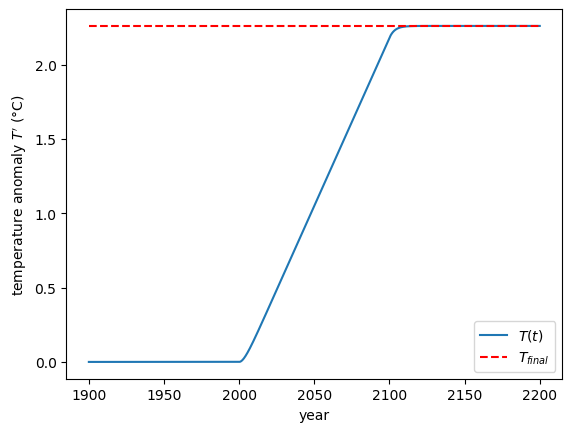

In [46]:
plot(t/sec_in_year,ustrip.(T),label=L"$T(t)$")
xlabel("year")
ylabel(L"temperature anomaly $T'$ ($\degree$C)");
plot([1900,2200],[ustrip(Ffinal/B),ustrip(Ffinal/B)],"r--",label=L"$T_{final}$")
legend();

# Exercise

1. What happens if you increase $H$ from $100$ m to $4000 m$ (the average depth of the ocean), meaning that heat is mixed throughout the entire depth of the ocean on a timescale of just a few years?
2. How much global warming occurs by 2100 if we pick more realistic values of $H = 300$ m and $B = 1$ W K$^{-1}$m $^{-2}$? 

(Note: $H = 300$ m and $B = 1$ W K$^{-1}$m $^{-2}$ are more realistic parameter choices in the sense that they are based on ocean mixing and radiative feedbacks in state-of-the-art climate models.)